# Analysis for Insight Project

## Setup

In [40]:
# import modules
import pandas as pd
import numpy as np
import rootpath
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import sklearn.metrics as metrics
from sklearn.utils import resample
import qgrid
import matplotlib.pyplot as plt

# Set root path for project
path = rootpath.detect()

# Read in data
# Use list comprehension to read in all files
df = pd.read_csv(f"{path}/data/data_clean.csv", index_col=0).reset_index(drop=True)

In [284]:
# Product type validation
df = pd.read_csv(f"{path}/data/data_clean_prodtype_valid.csv", index_col=0).reset_index(drop=True)

In [564]:
df[df['brand']=="SUNDAY RILEY"]

,product,brand,product_type,active,price,size,ratings,total_reviews,link,price_oz,0,1
243,Ceramic Slip Cleanser,SUNDAY RILEY,face wash,no_actives,35.0,5.00,3.2,33,https://www.ulta.com/ceramic-slip-cleanser?pro...,7.00,-14.211832,15.635860
295,Pink Drink Firming Resurfacing Essence,SUNDAY RILEY,toner,no_actives,48.0,6.75,5.0,2,https://www.ulta.com/pink-drink-firming-resurf...,7.11,-0.233837,-17.874914
865,Good Genes All-In-One Lactic Acid Treatment,SUNDAY RILEY,face serum,no_actives,85.0,1.00,4.1,104,https://www.ulta.com/good-genes-all-in-one-lac...,85.00,9.746774,-2.926974
866,A+ High-Dose Retinoid Serum,SUNDAY RILEY,face serum,no_actives,85.0,1.00,4.4,30,https://www.ulta.com/a-high-dose-retinoid-seru...,85.00,4.644239,-1.574981
867,C.E.O. 15% Vitamin C Brightening Serum,SUNDAY RILEY,face serum,no_actives,85.0,1.00,3.8,43,https://www.ulta.com/ceo-15-vitamin-c-brighten...,85.00,13.503988,-11.133731


In [602]:
#df.head()
df.shape

(853, 20)

In [285]:
#features = df.copy().set_index('product')
# Old, before dimensionality reduction
features = df.copy().drop(['product_type','brand', 'price','size','ratings', 'active','vit_a',
                           'total_reviews','link','price_oz'],
                          axis=1).set_index('product')
#features.head(100)

## K-means++

#### Run K-means and determine number of clusters based on silhouette coef

In [173]:
# Set cluster arguments
kmeans_kwargs = {
        "init": "k-means++",
        "n_init": 10,
        "max_iter": 300,
        "random_state": 42,
        }

In [174]:
silhouette_coefficients = []

# Get silhouette coefficient for each cluster out of 50
for cluster in range(2, 20):
    kmeans = KMeans(n_clusters=cluster, **kmeans_kwargs)
    kmeans.fit(features)
    score = silhouette_score(features, kmeans.labels_)
    silhouette_coefficients.append(score)

#### Plot silhouette coefficients vs. clusters

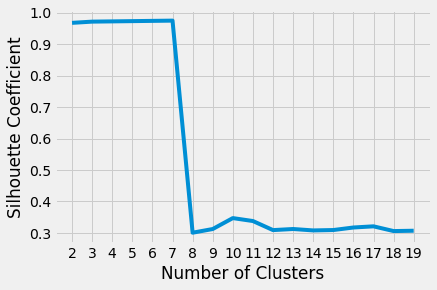

In [175]:
plt.style.use("fivethirtyeight")
plt.plot(range(2, 20), silhouette_coefficients)
plt.xticks(range(2, 20))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

In [ ]:
# Add cluster labels to features


## DBSCAN

In [417]:
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

In [435]:
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(features)
distances, indices = nbrs.kneighbors(features)

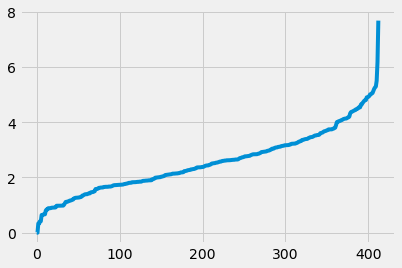

In [436]:
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

In [437]:
dbsc = DBSCAN(eps = 5, min_samples = 5).fit(features)
labels = dbsc.labels_
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(features, labels))


Estimated number of clusters: 1
Estimated number of noise points: 13
Silhouette Coefficient: 0.335


## Hierarchical/Agglomerative clustering

In [607]:
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch

# Plot clustering results

# for index, metric in enumerate(["cosine", "euclidean", "cityblock"]):
#     model = AgglomerativeClustering(n_clusters=n_clusters,
#                                     linkage="average", affinity=metric)
#     model.fit(features)
#     plt.figure()
#     plt.axes([0, 0, 1, 1])
#     for l, c in zip(np.arange(model.n_clusters), 'rgbk'):
#         plt.plot(features[model.labels_ == l].T, c=c, alpha=.5)
#     plt.axis('tight')
#     plt.axis('off')
#     plt.suptitle("AgglomerativeClustering(affinity=%s)" % metric, size=20)


# plt.show()

cluster = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward')  
y_hc =cluster.fit_predict(features)

#plt.scatter(features[:,1],features[:,2], c=cluster.labels_, cmap='rainbow')
# plt.scatter(features[y_hc ==0,0], features[y_hc == 0,1], s=100, c='red')
# plt.scatter(features[y_hc==1,0], features[y_hc == 1,1], s=100, c='black')
# plt.scatter(features[y_hc ==2,0], features[y_hc == 2,1], s=100, c='blue')
# plt.scatter(features[y_hc ==3,0], features[y_hc == 3,1], s=100, c='cyan')

In [584]:
features['cluster_labels'] = y_hc

In [585]:
features.head()

,0,1,2,3,4,5,6,7,8,9,...,191,192,193,194,195,196,197,198,199,cluster_labels
product,,,,,,,,,,,,,,,,,,,,,
The Microdelivery Exfoliating Facial Wash,1.225257,-0.831471,1.085914,0.199215,0.165847,-0.155683,0.247914,-0.088967,0.128975,-0.095547,...,0.018721,0.002497,-0.000112,0.035511,0.016232,0.056432,-0.024071,-0.001694,0.077221,0
AHA/BHA Exfoliating Cleanser,1.809298,-1.060433,0.882881,0.055500,0.234946,0.353983,-0.181930,0.219278,-0.083361,0.131203,...,0.026904,-0.050614,-0.131670,-0.038460,-0.002883,0.127456,-0.034768,0.034917,-0.037506,0
Hydrating Facial Cleanser,1.818391,-0.935320,0.792429,-0.170304,0.228655,-0.111074,-0.175043,-0.202005,-0.271360,0.301803,...,-0.209259,0.003113,-0.134940,0.051685,0.112461,0.000606,-0.011100,0.003331,0.005446,1
Anti-Aging Cleansing Gel,1.826982,-1.030466,0.869849,-0.058911,0.029676,0.357792,-0.382368,0.322961,-0.053760,-0.038201,...,-0.023535,0.036525,-0.075986,-0.044725,0.060956,-0.112853,0.073869,0.067343,-0.017364,0
Essential-C Cleanser,2.232532,-0.818987,0.772971,0.280153,0.337319,0.206010,-0.421622,0.500059,0.022538,-0.099224,...,0.192014,-0.030955,-0.227304,0.010332,-0.115268,-0.053123,-0.252086,-0.080943,-0.094681,0


In [608]:
plt.figure(figsize=(10, 7))  
plt.scatter(features['0'], features['1'], c=features['cluster_labels']) 

KeyError: 'cluster_labels'

<Figure size 720x504 with 0 Axes>

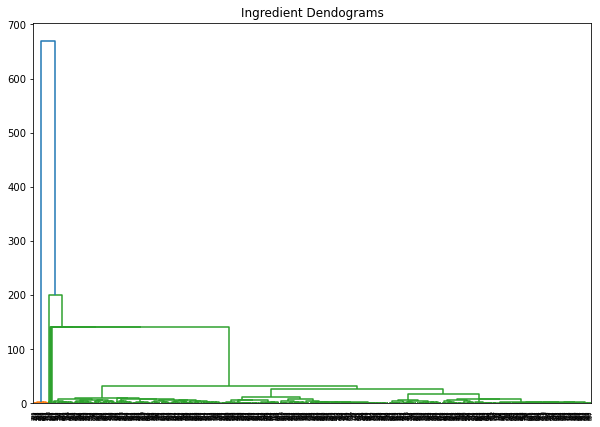

In [170]:
import scipy.cluster.hierarchy as shc

plt.figure(figsize=(10, 7))
plt.title("Ingredient Dendograms")
dend = shc.dendrogram(shc.linkage(features, method='ward'))

## Gaussian Mixture models

In [171]:
from sklearn.mixture import GaussianMixture as GMM
#from sklearn.mixture import GMM
gmm = GMM(n_components=4).fit(features)
labels = gmm.predict(features)

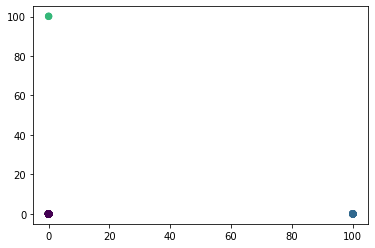

In [172]:
plt.scatter(features.iloc[:, 0], features.iloc[:, 1], c=labels, s=40, cmap='viridis')

Text(0.5, 0, 'n_components')

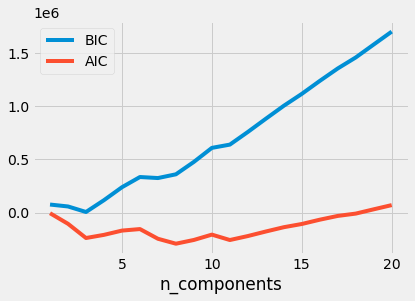

In [456]:
n_components = np.arange(1, 21)
models = [GMM(n, covariance_type='full', random_state=0).fit(features)
          for n in n_components]

plt.plot(n_components, [m.bic(features) for m in models], label='BIC')
plt.plot(n_components, [m.aic(features) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components')

In [ ]:
n_components = np.arange(1, 21)
models = [GMM(n, covariance_type='full', random_state=0).fit(features)
          for n in n_components]

plt.plot(n_components, [m.bic(features) for m in models], label='BIC')
plt.plot(n_components, [m.aic(features) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components')

## Pearson correlation

In [459]:
from sklearn.metrics import pairwise_distances

In [465]:
res_pearson = pairwise_distances(features.loc['Gentle Skin Cleanser',:].to_frame().transpose(), features,
                             metric='correlation') #[0:1] .loc["Essential-C Cleanser",:]
res_pearson

array([[0.6659717 , 0.65244956, 0.65833056, 0.64335864, 0.56099857,
        0.4287003 , 0.64115638, 0.65178082, 0.75585038, 0.7784969 ,
        0.37403556, 0.51420108, 0.35650727, 0.6124025 , 0.34853841,
        0.6836847 , 0.72785581, 0.87135438, 0.65260959, 0.65107936,
        0.60936829, 0.71738867, 0.67516719, 0.30237294, 0.7367131 ,
        0.5757427 , 0.61580584, 0.4609563 , 0.43872098, 0.88477554,
        0.58673214, 0.75242958, 0.67046645, 0.42054256, 0.75551712,
        0.83280832, 0.47495109, 0.61112765, 0.65054406, 0.73940975,
        0.7391732 , 0.75976675, 0.3984938 , 0.71547664, 0.68477574,
        0.60670738, 0.71578729, 0.49856663, 0.5815316 , 0.61508239,
        0.66406859, 0.65306131, 0.8609149 , 0.61111591, 0.75656364,
        0.66619389, 0.70578902, 0.71064032, 0.53261339, 0.7726461 ,
        0.27510447, 0.7075833 , 0.61365785, 0.64829463, 0.65780688,
        0.7075833 , 0.53212903, 0.74474819, 0.56340711, 0.55120436,
        0.61752173, 0.66328742, 0.68067665, 0.51

In [125]:
res_pearson = res_pearson.reshape(-1)
res_pearson = pd.DataFrame(res_pearson)
res_sim=df[['product','brand','product_type','price','size','ratings',
            'total_reviews','link','price_oz']].copy()
res_sim['similarity']=res_pearson[[0]]
# Round similarity metric
#res_sim['similarity']=round(res_sim['similarity'],2)
# Maybe don't round so you don't have to deal with ties?
#indexNames = res_sim[res_sim['product']=='Essential-C Cleanser'].index
#res_sim.drop(indexNames, inplace=True)
# Sort from top similarity metrics and ignoring self, so starting at 1, not zero
test = res_sim.nlargest(10, 'similarity')[1:10]
#res_sim.head()
# Select top match
test#[:1]

NameError: name 'res_pearson' is not defined

## Euclidean similarity

In [467]:
from sklearn.metrics import pairwise_distances
import heapq as hq

In [479]:
res_euc = pairwise_distances(features.loc['Gentle Skin Cleanser',:].to_frame().transpose(), features,
                             metric='euclidean') #[0:1] .loc["Essential-C Cleanser",:]
res_euc

array([[2.51678287, 2.33142432, 2.42849237, 2.3516415 , 2.74855314,
        1.95716933, 2.74452158, 2.89868572, 3.9829232 , 4.29047748,
        1.73297626, 2.42100615, 1.75963736, 2.19047426, 1.84817541,
        3.14575898, 3.51311736, 3.95159575, 2.37246507, 2.36048906,
        2.52256884, 3.45346666, 2.50148726, 1.64919185, 3.63089822,
        2.30893004, 2.65989352, 2.06113448, 1.94171032, 3.97566301,
        2.37263984, 3.82783308, 2.97006306, 1.89642226, 3.99874796,
        3.21055362, 2.4302471 , 2.57463623, 2.29409136, 3.89521447,
        2.39991795, 4.0063986 , 1.82504003, 3.36528216, 3.10630097,
        2.23136259, 3.36952555, 2.29178832, 3.19704216, 2.63099639,
        4.07027635, 3.17384605, 3.65512622, 2.56129209, 3.96560206,
        2.62396166, 4.76051565, 3.34166219, 2.82192039, 4.17852233,
        1.50150605, 3.3618171 , 2.56968273, 2.35973142, 3.7541872 ,
        3.3618171 , 2.15081486, 3.78289062, 2.31771648, 2.93331729,
        2.79883039, 2.93085612, 3.05639757, 2.68

In [480]:
res_euc = res_euc.reshape(-1)
res_euc = pd.DataFrame(res_euc)
res_sim=df[['product','brand','product_type','price','size','ratings',
            'total_reviews','link','price_oz']].copy()
res_sim['similarity']=res_euc[[0]]
# Round similarity metric
#res_sim['similarity']=round(res_sim['similarity'],2)
# Maybe don't round so you don't have to deal with ties?
#indexNames = res_sim[res_sim['product']=='Essential-C Cleanser'].index
#res_sim.drop(indexNames, inplace=True)
# Sort from top similarity metrics and ignoring self, so starting at 1, not zero
test = res_sim.nsmallest(10, 'similarity')[1:10]
#res_sim.head()
# Select top match
test#[:1]

,product,brand,product_type,price,size,ratings,total_reviews,link,price_oz,similarity
60,Vital Vita 12 Jelly Cleanser,TONYMOLY,face wash,18.00,5.0,4.2,15.0,https://www.ulta.com/vital-vita-12-jelly-clean...,3.60,1.501506
111,Foaming Facial Wash,Curél,face wash,20.00,5.0,4.6,240.0,https://www.ulta.com/foaming-facial-wash?produ...,4.00,1.636158
23,Orange Cleansing Soap,Mario Badescu,face wash,12.00,8.0,4.0,159.0,https://www.ulta.com/orange-cleansing-soap?pro...,1.50,1.649192
87,SkinActive Micellar Cleansing Water All-in-1 C...,Garnier,face wash,4.99,3.3,4.3,1726.0,https://www.ulta.com/skinactive-micellar-clean...,1.51,1.705777
99,AHA/BHA Acne Clearing Gel,Peter Thomas Roth,face wash,54.00,3.4,4.3,77.0,https://www.ulta.com/ahabha-acne-clearing-gel?...,15.88,1.726108
10,SkinActive Micellar Cleansing Water with Rose ...,Garnier,face wash,8.99,13.5,4.7,679.0,https://www.ulta.com/skinactive-micellar-clean...,0.67,1.732976
12,Oil-Free Acne Wash Pink Grapefruit Facial Clea...,Neutrogena,face wash,9.99,6.0,4.0,2646.0,https://www.ulta.com/oil-free-acne-wash-pink-g...,1.66,1.759637
42,All Bright Cleansing Foam Wash,Botanics,face wash,6.99,5.0,4.2,218.0,https://www.ulta.com/all-bright-cleansing-foam...,1.40,1.825040
14,Chamomile Cleansing Lotion,Mario Badescu,face wash,15.00,8.0,3.9,13.0,https://www.ulta.com/chamomile-cleansing-lotio...,1.88,1.848175


## Cosine similarity

In [11]:
from sklearn.metrics.pairwise import cosine_similarity
import heapq as hq

In [150]:
features.loc['Good Genes All-In-One Lactic Acid Treatment',:].to_frame().transpose()

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
Good Genes All-In-One Lactic Acid Treatment,0.00004,0.010181,0.007252,-0.003392,0.000209,0.000484,0.588688,0.143943,-0.69762,-0.755284,...,-0.265798,0.060481,-0.257833,-0.030133,0.167019,-0.003906,0.109727,0.09028,0.03137,-0.071883


In [116]:
features.head()

,0,1,2,3,4,5,6,7,8,9,...,70,71,72,73,74,75,76,77,78,79
product,,,,,,,,,,,,,,,,,,,,,
The Microdelivery Exfoliating Facial Wash,0.005109,0.026388,0.019139,0.015737,0.011804,0.040523,0.047470,-0.000057,1.208755,-0.780488,...,-0.085563,-0.110450,-0.023823,0.084598,-0.003582,0.005568,0.159749,0.063010,-0.093492,0.007545
AHA/BHA Exfoliating Cleanser,0.014445,0.036547,0.032800,0.021612,0.022671,0.064152,0.055410,0.008444,1.785970,-1.018542,...,-0.216673,0.048243,0.148549,-0.182165,-0.094474,-0.170695,-0.110881,0.030453,-0.014132,-0.133672
Hydrating Facial Cleanser,0.014445,0.033173,0.034367,0.024020,0.022706,0.062177,0.054629,0.008891,1.798739,-0.902756,...,-0.087101,0.180479,0.144983,0.082328,-0.150458,0.048643,0.111913,0.125662,-0.007605,0.081093
Anti-Aging Cleansing Gel,0.014448,0.036702,0.033722,0.026482,0.022708,0.063742,0.052493,0.010148,1.804293,-0.991571,...,-0.220594,0.069816,-0.105584,0.074536,0.268280,-0.076265,-0.089639,0.119799,0.003991,-0.094210
Essential-C Cleanser,0.016270,0.039849,0.048622,0.035795,0.028372,0.100810,0.055377,0.008740,2.257349,-0.819252,...,-0.285106,0.073398,0.197005,0.022470,0.183490,0.038499,-0.150709,0.134890,-0.255228,-0.114078


In [158]:
df

,product,brand,product_type,active,price,size,ratings,total_reviews,link,price_oz,...,41,42,43,44,45,46,47,48,49,vit_a
0,The Microdelivery Exfoliating Facial Wash,Philosophy,face wash,no_actives,29.00,8.00,4.5,812,https://www.ulta.com/microdelivery-exfoliating...,3.62,...,0.025182,-0.027935,0.048542,0.168888,-0.064342,-0.029877,0.023201,-0.050958,-0.074378,0
1,AHA/BHA Exfoliating Cleanser,Murad,face wash,no_actives,40.00,6.75,4.6,267,https://www.ulta.com/ahabha-exfoliating-cleans...,5.93,...,0.145476,0.023719,0.078348,-0.187813,0.074210,0.173912,0.006308,0.105570,0.038466,0
2,Hydrating Facial Cleanser,CeraVe,face wash,no_actives,13.49,8.00,4.2,700,https://www.ulta.com/hydrating-facial-cleanser...,1.69,...,0.134936,-0.012049,0.238888,-0.189581,-0.185041,-0.154400,0.117378,-0.028735,0.241734,1
3,Anti-Aging Cleansing Gel,Peter Thomas Roth,face wash,no_actives,39.00,8.50,4.5,330,https://www.ulta.com/anti-aging-cleansing-gel?...,4.59,...,0.125236,0.269273,0.142161,-0.001903,0.021177,0.108418,-0.010157,-0.007142,0.047504,1
4,Essential-C Cleanser,Murad,face wash,no_actives,40.00,6.75,4.6,272,https://www.ulta.com/essential-c-cleanser?prod...,5.93,...,0.097427,0.082206,0.236783,-0.321999,-0.282681,0.055476,-0.209665,0.014304,-0.161765,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
848,Antiplaque & Whitening Toothpaste Peppermint,Tom's of Maine,toothpaste,no_actives,4.69,5.50,4.7,40,https://www.walgreens.com/store/c/tom's-of-mai...,0.85,...,0.236100,0.034250,-0.077789,0.038679,0.254285,0.001381,0.121588,0.084932,0.046293,0
849,Anticavity Fluoride Toothpaste with Whitening ...,Colgate MaxFresh,toothpaste,no_actives,3.49,6.00,4.7,71,https://www.walgreens.com/store/c/colgate-maxf...,0.58,...,0.288956,0.129749,-0.478267,0.129268,0.412880,0.080882,0.295295,-0.081433,0.013384,0
850,Good Genes All-In-One Lactic Acid Treatment,SUNDAY RILEY,face serum,no_actives,85.00,1.00,4.1,104,https://www.ulta.com/good-genes-all-in-one-lac...,85.00,...,0.060481,-0.257833,-0.030133,0.167019,-0.003906,0.109727,0.090280,0.031370,-0.071883,0
851,A+ High-Dose Retinoid Serum,SUNDAY RILEY,face serum,no_actives,85.00,1.00,4.4,30,https://www.ulta.com/a-high-dose-retinoid-seru...,85.00,...,0.255389,-0.131660,-0.290169,0.536320,0.232750,0.144092,0.310105,0.207430,0.222960,0


In [177]:
#features = df.copy().set_index('product')
# Old, before dimensionality reduction
df_temp = df.copy()

# If active ingredient, paste to other column for text parsing
# - Make two columns, one for ingredient name, the other for the value
df_temp2 = df_temp.loc[df_temp['vit_a']==1]

features = df_temp2.copy().drop(['product_type','brand', 'price','size','ratings', 'active','vit_a',
                           'total_reviews','link','price_oz'],
                          axis=1).set_index('product')
features.head(10)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
product,,,,,,,,,,,,,,,,,,,,
+Retinol Vita C Power Serum Firming + Brightening Treatment,0.010543,0.021712,0.041526,-0.007964,0.008131,0.013705,1.546059,-0.784426,-0.927136,-0.296286,-0.180750,0.662652,0.342097,-0.099919,0.078950,-0.121042,-0.036390,0.165403,-0.132104,0.208711
+Retinol Vitamin C Moisturizer,0.024541,0.059035,0.094709,-0.003740,0.022303,0.016154,2.443386,1.480570,-0.303838,-0.300337,-0.936772,0.819595,0.433277,-0.119486,0.340504,-0.178119,-0.172269,0.769385,-0.198510,0.076714
A+ High-Dose Retinoid Serum,0.001380,0.016536,0.032617,-0.017725,-0.001816,0.005483,1.018974,-0.009259,-0.763412,0.151360,-0.298005,0.510818,0.812463,-0.803347,0.317402,-1.027187,-0.836786,0.351216,-0.172856,0.120300
Advanced Retinol Concentrated Serum,0.010536,0.019424,0.046780,-0.011827,0.007132,0.013390,1.464425,-0.902326,-0.900302,-0.257268,0.005005,0.827391,0.157290,-0.332639,0.045609,0.100997,-0.141796,0.081649,0.025572,0.198571
Age Reform Hydro-Dynamic Ultimate Moisture,0.024552,0.062415,0.111476,-0.014952,0.020147,0.013803,2.560652,1.688340,-0.363892,-0.287507,-0.389787,1.680109,0.292020,0.345205,1.267809,0.281602,0.264439,-0.490418,-0.015942,-0.656140
Age Reverse Day Repair SPF 30 + Retinol Antiaging Moisturizer,0.024514,0.038694,0.089807,-0.009499,0.022937,0.022772,2.251645,-0.012314,-0.485396,-0.665636,-0.189895,0.892348,0.530705,-0.207842,-0.772227,0.453272,0.414331,-0.084693,0.044170,0.004579
Age Reverse Night Lift Antiaging Moisturizer,0.010541,0.020601,0.047335,-0.011924,0.007258,0.014212,1.514145,-0.773622,-0.867968,-0.335179,-0.295299,0.916815,0.165021,0.168435,-0.316292,0.009947,0.203916,0.010085,-0.052283,0.079613
Age Smart Multivitamin Power Serum,0.010532,0.019187,0.043343,-0.009744,0.007486,0.013431,1.409900,-0.914763,-0.861463,-0.334756,-0.133432,0.691261,0.151414,-0.235097,-0.129866,0.070495,-0.104770,0.171589,-0.086445,0.064173
All-Over Wash,0.014491,0.026168,0.070238,-0.005014,0.015964,0.035243,2.035282,-0.553286,0.849459,-0.235109,-0.284662,1.002260,-0.132088,-0.055019,0.295183,-0.028022,0.054240,0.181846,-0.272509,0.180605


In [162]:
features.loc['A+ High-Dose Retinoid Serum',:].to_frame().transpose()

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
A+ High-Dose Retinoid Serum,0.001346,0.00624,0.020541,-0.013115,-0.001718,0.000246,0.639218,-0.048714,-0.79394,-0.43607,...,-0.456678,0.255389,-0.13166,-0.290169,0.53632,0.23275,0.144092,0.310105,0.20743,0.22296


In [25]:
# Calculate cosine similarity for feature 1 
res_cosine = cosine_similarity(features.loc['Aveeno Positively Radiant Brightening & Exfoliating Face Scrub',:].to_frame().transpose(), features) #[0:1] .loc["Essential-C Cleanser",:]
res_cosine = res_cosine.reshape(-1)
res_cosine = pd.DataFrame(res_cosine)
res_sim=df[['product','brand','product_type','price','size','ratings', 'active','vit_a',
            'total_reviews','link','price_oz']].copy()
res_sim['similarity']=res_cosine[[0]]
# Round similarity metric
#res_sim['similarity']=round(res_sim['similarity'],2)
# Maybe don't round so you don't have to deal with ties?
#indexNames = res_sim[res_sim['product']=='Essential-C Cleanser'].index
#res_sim.drop(indexNames, inplace=True)
# Sort from top similarity metrics and ignoring self, so starting at 1, not zero
test = res_sim.nlargest(5, 'similarity')[1:5]
#res_sim.head()
# Select top match
test[:10]
#Good Genes All-In-One Lactic Acid Treatment
#A+ High-Dose Retinoid Serum
# Generic vs similar validation
# Cetaphil Daily Facial Cleanser
# Cetaphil Fragrance Free Moisturizing Cream : 0.959282
# Banana Boat Ultra Sport Sunscreen Lotion, Broad Spectum SPF 30 : 0.999971
# St. Ives Fresh Skin Face Scrub, Apricot : 0.999748
# Clean & Clear Essentials Deep Cleaning Toner Sensitive Skin : 0.999994
# Aveeno Positively Radiant Brightening & Exfoliating Face Scrub : 0.990599

#test[test['vit_a']==1]

,product,brand,product_type,price,size,ratings,active,vit_a,total_reviews,link,price_oz,similarity
106,Beauty 360 Illuminating Facial Scrub,Beauty 360,face wash,7.49,5.0,4.4,no_actives,0,8,https://www.cvs.com/shop/beauty-360-illuminati...,1.50,0.990599
154,Cetaphil Daily Facial Cleanser,Cetaphil,face wash,6.33,8.0,4.7,no_actives,0,644,https://www.amazon.com/Cetaphil-Daily-Facial-C...,0.79,0.987227
72,"Amazon Brand - Solimo Daily Facial Cleanser, N...",Solimo,face wash,4.44,8.0,4.3,no_actives,0,867,https://www.amazon.com/Amazon-Brand-Solimo-Fac...,0.56,0.982133
305,Extreme Whitening Control with Baking Soda & P...,Arm & Hammer Advance White,toothpaste,3.09,6.0,4.5,no_actives,0,141,https://www.walgreens.com/store/c/arm-%26-hamm...,0.52,0.920256


In [554]:
res_sim.columns

Index(['product', 'brand', 'product_type', 'price', 'size', 'ratings',
       'active', 'total_reviews', 'link', 'price_oz', 'similarity'],
      dtype='object')

In [32]:
res_cosine = cosine_similarity(features.loc['A+ High-Dose Retinoid Serum',:].to_frame().transpose(), features) #[0:1] .loc["Essential-C Cleanser",:]
res_cosine = res_cosine.reshape(-1)
res_cosine = pd.DataFrame(res_cosine)
res_sim=df[['product','brand','product_type','price','size','ratings', 'active',
            'total_reviews','link','price_oz']].copy()
res_sim['similarity']=res_cosine[[0]]
# Round similarity metric
#res_sim['similarity']=round(res_sim['similarity'],2)
# Maybe don't round so you don't have to deal with ties?

# Sort from top similarity metrics and ignoring self, so starting at 1, not zero
test = res_sim.nlargest(6, 'similarity')[0:6]
#res_sim.head()
# Select top match
test['product_type']#.loc[test['product']=='A+ High-Dose Retinoid Serum',['product_type']]

18     face serum
632    face serum
387    face serum
138    face serum
645    face serum
372    face serum
Name: product_type, dtype: object

In [41]:
res_temp = np.where(test['product_type']==test.loc[test['product']=='A+ High-Dose Retinoid Serum',['product_type']].values[0], 1, 0)  

ValueError: ('Lengths must match to compare', (6,), (1,))

In [33]:
test

,product,brand,product_type,price,size,ratings,active,total_reviews,link,price_oz,similarity
18,A+ High-Dose Retinoid Serum,SUNDAY RILEY,face serum,85.00,1.0,4.4,no_actives,30,https://www.ulta.com/a-high-dose-retinoid-seru...,85.00,1.000000
632,Radically Rejuvenating Dual Phase Bakuchiol Serum,ACURE,face serum,19.99,0.6,4.3,no_actives,7,https://www.ulta.com/radically-rejuvenating-du...,33.32,0.843894
387,Honestly Pure Retinol Serum,Honest Beauty,face serum,28.00,1.0,4.5,no_actives,34,https://www.ulta.com/honestly-pure-retinol-ser...,28.00,0.843711
138,C.E.O. 15% Vitamin C Brightening Serum,SUNDAY RILEY,face serum,85.00,1.0,3.8,no_actives,43,https://www.ulta.com/ceo-15-vitamin-c-brighten...,85.00,0.831624
645,Rapid Wrinkle Repair Serum,Neutrogena,face serum,26.99,1.0,4.0,no_actives,294,https://www.ulta.com/rapid-wrinkle-repair-seru...,26.99,0.798791
372,Hello Radiance Illuminating Serum,Tula,face serum,68.00,1.7,4.5,no_actives,107,https://www.ulta.com/hello-radiance-illuminati...,40.00,0.772907


In [86]:

# tmp_prodtype = test.loc[test['product']==product,['product_type']].values[0]
# tmp_prodtype
#test['product'].values
for i,product in enumerate(test['product'].values):
    prod_name = test['product'].values[i]
    print(prod_name)
prod_name

A+ High-Dose Retinoid Serum
C.E.O. 15% Vitamin C Brightening Serum
Multi Correxion Revive + Glow Daily Serum
Quench Hydrating Face Serum
Peptight Tightening & Brightening Face Serum
Midnight Recovery Concentrate


'Midnight Recovery Concentrate'

In [89]:
test.loc[test['product']==prod_name,['product_type']].values[0]
#tmp_prodtype = test.loc[test['product']==prod_name,['product_type']].values[0]
#tmp_prodtype

array(['face serum'], dtype=object)

In [34]:
test['product_type'].isin(tmp_prodtype).sum()

6

In [78]:
cosine_similarity(features.loc[prod_name,:].to_frame().transpose(), features)

array([[ 7.94104093e-02,  3.53716222e-01,  4.12871702e-01,
         3.70933394e-01,  4.41839069e-01,  4.67051982e-01,
         4.04418691e-01,  4.53647735e-01,  4.02673602e-01,
         3.95732397e-01,  3.61079395e-01,  1.67131271e-01,
         4.32898611e-01,  1.28107825e-01,  4.13221269e-01,
         1.09390707e-01,  6.89718329e-02,  4.03762969e-01,
         3.64860483e-01,  9.21171130e-02,  3.82892202e-01,
         3.97003680e-01,  7.36613932e-03,  1.13943465e-01,
         5.19114246e-01,  1.63084185e-01,  5.08419316e-01,
         8.89989841e-02,  3.46721606e-01,  4.46964303e-02,
         4.07741993e-01,  4.16240459e-01,  3.94241278e-01,
         3.99210606e-01,  3.74027391e-01,  5.13957018e-01,
         3.88619629e-01,  5.08520399e-01,  3.88501737e-01,
         3.80172042e-01,  6.03015670e-02,  3.94832429e-01,
         3.81267024e-01, -5.84809358e-06,  4.14851264e-01,
         8.97283694e-02,  1.28626147e-01,  4.14797246e-01,
         3.98664538e-01,  1.14174594e-01,  1.39883980e-0

In [35]:
product = 'A+ High-Dose Retinoid Serum'
#test.loc[test['product']=='A+ High-Dose Retinoid Serum',['product_type']]
test.loc[test['product']==product,['product_type']].values[0]

array(['face serum'], dtype=object)

In [37]:
test.loc[test['prodtype_match_tot'],1]#.append(tmp_top_sim['product_type'].isin(tmp_prodtype).sum()-1)

KeyError: 'prodtype_match_tot'

In [45]:
# Create temp df for troubleshooting for loop
df_temp = df.copy()[:5]
df_temp

,product,brand,product_type,active,price,size,ratings,total_reviews,link,price_oz,...,11,12,13,14,15,16,17,18,19,vit_a
0,''Buffet'',The Ordinary,face serum,no_actives,14.80,1.0,4.4,333,https://www.ulta.com/buffet?productId=pimprod2...,14.80,...,-0.129916,0.126002,0.162188,-0.246412,0.017430,-0.325152,0.255324,-0.063510,-0.118330,0
1,''Buffet'' + Copper Peptides 1%,The Ordinary,face serum,no_actives,28.90,1.0,4.3,52,https://www.ulta.com/buffet-copper-peptides-1?...,28.90,...,-0.148335,0.117411,0.137886,-0.241574,-0.001409,-0.305912,0.250620,-0.068237,-0.123871,0
2,+Retinol Vita C Power Serum Firming + Brighten...,Kate Somerville,face serum,no_actives,98.00,1.0,4.3,47,https://www.ulta.com/retinol-vita-c-power-seru...,98.00,...,-0.404009,0.181768,-0.397968,0.094172,0.251226,0.178438,-0.211869,0.587289,0.380548,1
3,+Retinol Vitamin C Moisturizer,Kate Somerville,face moisturizer,no_actives,90.00,1.7,3.7,10,https://www.ulta.com/retinol-vitamin-c-moistur...,52.94,...,-0.670978,-0.556725,-0.595433,0.108214,0.542305,0.756320,-0.124922,0.818436,0.932956,1
4,1000 Roses Cleansing Foam,Andalou Naturals,face wash,no_actives,12.99,0.6,4.8,10,https://www.ulta.com/1000-roses-cleansing-foam...,21.65,...,-0.052668,-0.605225,-0.067271,0.372837,0.154673,-0.854062,0.401039,-0.344363,0.513854,0


In [13]:
# Troubleshooting
# Create features
features = df.copy().drop(['product_type','brand', 'price','size','ratings', 'active','vit_a',
                           'total_reviews','link','price_oz'],
                          axis=1).set_index('product')

In [14]:
# Troubleshooting for loop

# df to store results
res_sim_prodtype=df[['product','brand','product_type']].copy()

# add empty column for storing results
#res_sim_prodtype['prodtype_match_tot'] = np.nan

prodtype_match_tot = []
#prodtype_match_tot
#

# for each product in df, 
# 1. Get top 6 similiar products, including self
# 2. Count number of products, excluding self, that match input product type
# 3. Add result to df for each product
for i in range(df.shape[0]):
    # Get product name value
    prod_name = df['product'].iloc[i]
    # Calc cosine similarity for the product
    tmp_cosine = cosine_similarity(features.loc[prod_name,:].to_frame().transpose(), features)
    tmp_cosine = tmp_cosine.reshape(-1)
    tmp_cosine = pd.DataFrame(tmp_cosine)
    # Copy df for storing tmp similarity result
    tmp_sim=df[['product','brand','product_type','price','price_oz']].copy()
    # Add similarity to df
    tmp_sim['similarity']=tmp_cosine[[0]]
    # Sort from top similarity metrics and extract top 6, including self
    tmp_top_sim = tmp_sim.nlargest(6, 'similarity')[0:6]
    # Store result in res_sim_prodtype df outside for loop
    if prod_name in tmp_top_sim['product']:
        ## Store input product type in tmp_prodtype
        tmp_prodtype = tmp_top_sim.loc[tmp_top_sim['product']==prod_name,['product_type']].values[0]
    else: 
        # If the top 6 products do not contain the product entered
        # Select top 5 rows, append the product entered similarity results to the 6th row 
        ## Store input product type in tmp_prodtype
        tmp_top_sim = tmp_top_sim[0:5].append(tmp_sim.loc[tmp_sim['product']==prod_name])
        tmp_prodtype = tmp_top_sim.loc[tmp_top_sim['product']==prod_name,['product_type']].values[0]
    ## Check match between input prod type and prod_types in sim output and sum matches
    ## -1 to account for matching with self
    prodtype_match_tot.append(tmp_top_sim['product_type'].isin(tmp_prodtype).sum()-1)

# Add for loop results to df
res_sim_prodtype['prodtype_match_tot'] = prodtype_match_tot

In [15]:
res_sim_prodtype.head()

,product,brand,product_type,prodtype_match_tot
0,''Buffet'',The Ordinary,face serum,5
1,''Buffet'' + Copper Peptides 1%,The Ordinary,face serum,5
2,+Retinol Vita C Power Serum Firming + Brighten...,Kate Somerville,face serum,5
3,+Retinol Vitamin C Moisturizer,Kate Somerville,face moisturizer,5
4,1000 Roses Cleansing Foam,Andalou Naturals,face wash,5


In [16]:
# Get mean proportions
# Empty df to temporarily store for loop rand results in for each iteration
df_temp = pd.DataFrame()
df_temp['prodtype_match_tot'] = res_sim_prodtype.groupby('product_type')['prodtype_match_tot'].mean()/5 * 100

#test.append()
#res_sim_prodtype['prodtype_match_tot'].mean()/5
df_temp.loc['overall'] = res_sim_prodtype['prodtype_match_tot'].mean()/5 * 100
# test
df_temp.reset_index(level=0, inplace=True)

In [17]:
df_temp.head()

,product_type,prodtype_match_tot
0,face moisturizer,98.954704
1,face serum,98.565401
2,face wash,99.325843
3,toner,97.108434
4,toothpaste,86.666667


In [24]:
# Extract proportion for one product type
df_temp.at[0,'prodtype_match_tot']

98.95470383275263

In [41]:
res_sim_prodtype

,product,brand,product_type,prodtype_match_tot
0,''Buffet'',The Ordinary,face serum,5
1,''Buffet'' + Copper Peptides 1%,The Ordinary,face serum,5
2,+Retinol Vita C Power Serum Firming + Brighten...,Kate Somerville,face serum,5
3,+Retinol Vitamin C Moisturizer,Kate Somerville,face moisturizer,5
4,1000 Roses Cleansing Foam,Andalou Naturals,face wash,5
...,...,...,...,...
875,Wrinkle Warrior 2-in-1 Plumping Moisturizer + ...,Kate Somerville,face moisturizer,5
876,Youth Serum,ARCONA,face serum,5
877,Youthful Vitamin C Fresh Radiance Essence,No7,face serum,5
878,Yuza Sorbet Day Cream,Erborian,face moisturizer,5


In [45]:
df_tmp_boot = resample(res_sim_prodtype, replace=True, n_samples=len(res_sim_prodtype))
df_tmp_boot

,product,brand,product_type,prodtype_match_tot
266,Dr. Andrew Weil for Origins Mega-Mushroom Reli...,Origins,face moisturizer,5
712,Seaweed Cleansing Soap,Mario Badescu,face wash,5
506,Multi-Active Day Cream SPF 20,Clarins,face moisturizer,5
288,Essential Fx Acyl-Glutathione Deep Crease Serum,Perricone MD,face serum,5
799,Truffle Therapy Power Duo,SKIN&CO,toner,5
...,...,...,...,...
479,Maracuja Oil,Tarte,face serum,5
125,Bright Boost Overnight Recovery Gel Cream,Neutrogena,face moisturizer,5
252,Deep Dive Glycolic Facial Cleanser,Jack Black,face wash,5
825,Ultra-Calming Daily Moisturizer SPF 15,Aveeno,face moisturizer,5


In [55]:
# Bootstrap confidence intervals

# Empty list to store boot results in
res_boot = []

for iteration in range(1000):
    # Bootstrap df with replacement 
    df_tmp_boot = resample(res_sim_prodtype, replace=True, n_samples=len(res_sim_prodtype))
    # Get mean proportions
    ## Empty df to temporarily store for loop rand results in for each iteration
    df_boot_temp = pd.DataFrame()
    ## Proportion matched by product type
    df_boot_temp['prodtype_match_tot'] = df_tmp_boot.groupby('product_type')['prodtype_match_tot'].mean()/5 * 100
    ## Overall proportion matched
    df_boot_temp.loc['overall'] = df_tmp_boot['prodtype_match_tot'].mean()/5 * 100
    ## clean up
    df_boot_temp.reset_index(level=0, inplace=True)
    ## Add iteration identifier
    df_boot_temp['iteration'] = iteration
    ## Append results to tmp list
    res_boot.append(df_boot_temp)

# Concatenate list results into a df    
df_boot_res = pd.concat(res_boot, ignore_index=True)

In [58]:
# Save bootstrap results
df_boot_res.to_csv(f"{path}/data/boot_prodtype_res.csv",index=True)

In [49]:
df_boot_res.head()

,product_type,prodtype_match_tot,iteration
0,face moisturizer,98.954704,0
1,face serum,98.565401,0
2,face wash,99.325843,0
3,toner,97.108434,0
4,toothpaste,86.666667,0


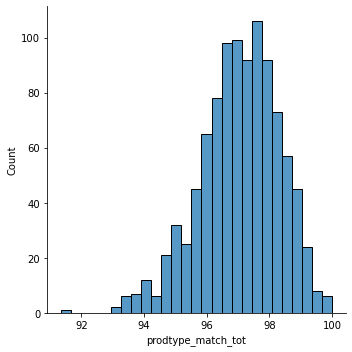

In [56]:
# Plot distribution of boot results

# Filter toners
df_boot_toner = df_boot_res.query("product_type=='toner'")

# plot toner null distribution
sns.displot(df_boot_toner, x="prodtype_match_tot")

In [59]:
df_boot_toner.head()

,product_type,prodtype_match_tot,iteration
3,toner,97.804878,0
9,toner,97.826087,1
15,toner,96.263736,2
21,toner,96.853933,3
27,toner,95.555556,4


In [79]:
# confidence intervals
alpha = 0.05

lower = round(np.percentile(df_boot_toner['prodtype_match_tot'], (alpha/2.0)),2)

upper = round(np.percentile(df_boot_toner['prodtype_match_tot'], ((100-alpha)/2.0)),2)

print(lower,upper)

91.8 97.14


In [97]:
1-0.05

0.95

In [100]:
94.81+2.12

96.93

In [95]:
round(np.quantile(df_boot_toner['prodtype_match_tot'], alpha),2)

94.81

In [96]:
round(np.quantile(df_boot_toner['prodtype_match_tot'], (1-alpha)),2)

98.93

In [83]:
np.percentile(df_boot_toner['prodtype_match_tot'], 2.5)

94.16615853658537

In [89]:
np.percentile(df_boot_toner['prodtype_match_tot'], 1-(alpha/2))

93.68245641344957

In [326]:
# Empty df to store randomization results in
#df_rand_res = pd.DataFrame(columns = ['product_type','prodtype_match_tot','iteration'])
test = []

# Empty df to temporarily store for loop rand results in for each iteration
df_temp = pd.DataFrame()
df_temp['prodtype_match_tot'] = res_sim_prodtype.groupby('product_type')['prodtype_match_tot'].mean()/5 * 100

#test.append()
#res_sim_prodtype['prodtype_match_tot'].mean()/5
df_temp.loc['overall'] = res_sim_prodtype['prodtype_match_tot'].mean()/5 * 100
# test
df_temp.reset_index(level=0, inplace=True)
df_temp['iteration'] = 1

df_temp
test.append(df_temp)


# Empty df to temporarily store for loop rand results in for each iteration
df_temp = pd.DataFrame()
df_temp['prodtype_match_tot'] = res_sim_prodtype.groupby('product_type')['prodtype_match_tot'].mean()/5 * 100

#test.append()
#res_sim_prodtype['prodtype_match_tot'].mean()/5
df_temp.loc['overall'] = res_sim_prodtype['prodtype_match_tot'].mean()/5 * 100
# test
df_temp.reset_index(level=0, inplace=True)
df_temp['iteration'] = 2

df_temp
test.append(df_temp)




df_rand_res = pd.concat(test, ignore_index=True)
df_rand_res.head(10)

,product_type,prodtype_match_tot,iteration
0,face moisturizer,98.954704,1
1,face serum,98.565401,1
2,face wash,99.325843,1
3,toner,97.108434,1
4,toothpaste,86.666667,1
5,overall,98.704545,1
6,face moisturizer,98.954704,2
7,face serum,98.565401,2
8,face wash,99.325843,2
9,toner,97.108434,2


In [306]:
len(range(5))

5

In [333]:
# Calculate the null probability of product means

from numpy import random

# Create a new copy of dataframe
df_rand = df.copy()

# Empty list to store randomization results in
tmp_list = []

# Extract features
features = df.copy().drop(['product_type','brand', 'price','size','ratings', 'active','vit_a',
                           'total_reviews','link','price_oz'],
                          axis=1).set_index('product')

# For loop for calculating the product type proportion means for each randomization for 1000 iterations
for iteration in range(1000):
    # Randomize the product type label
    df_rand['product_type'] = random.permutation(df['product_type'].values)
    # create df to store results of product type matches
    res_sim_prodtype=df[['product','brand','product_type']].copy()
    # Initialize an empty list to put product type matches in
    prodtype_match_tot = []
    # for each product in df, 
    # 1. Get top 6 similiar products, including self
    # 2. Count number of products, excluding self, that match input product type
    # 3. Add result to df for each product
    for i in range(df_rand.shape[0]):
        # Get product name value
        prod_name = df_rand['product'].iloc[i]
        # Calc cosine similarity for the product
        tmp_cosine = cosine_similarity(features.loc[prod_name,:].to_frame().transpose(), features)
        tmp_cosine = tmp_cosine.reshape(-1)
        tmp_cosine = pd.DataFrame(tmp_cosine)
        # Copy df for storing tmp similarity result
        tmp_sim=df_rand[['product','brand','product_type','price','price_oz']].copy()
        # Add similarity to df
        tmp_sim['similarity']=tmp_cosine[[0]]
        # Sort from top similarity metrics and extract top 6, including self
        tmp_top_sim = tmp_sim.nlargest(6, 'similarity')[0:6]
        # Store result in res_sim_prodtype df outside for loop
        if prod_name in tmp_top_sim['product']:
            ## Store input product type in tmp_prodtype
            tmp_prodtype = tmp_top_sim.loc[tmp_top_sim['product']==prod_name,['product_type']].values[0]
        else: 
            # If the top 6 products do not contain the product entered
            # Select top 5 rows, append the product entered similarity results to the 6th row 
            ## Store input product type in tmp_prodtype
            tmp_top_sim = tmp_top_sim[0:5].append(tmp_sim.loc[tmp_sim['product']==prod_name])
            tmp_prodtype = tmp_top_sim.loc[tmp_top_sim['product']==prod_name,['product_type']].values[0]
        ## Check match between input prod type and prod_types in sim output and sum matches
        ## -1 to account for matching with self
        prodtype_match_tot.append(tmp_top_sim['product_type'].isin(tmp_prodtype).sum()-1)
    # Add for loop results to df of product type matches
    res_sim_prodtype['prodtype_match_tot'] = prodtype_match_tot
    # Create new empty dataframe for mean proportion matches
    df_prop_prodtype_match = pd.DataFrame()
    # Add mean proportions for each product type
    df_prop_prodtype_match['prodtype_match_tot'] = res_sim_prodtype.groupby('product_type')['prodtype_match_tot'].mean()/5 * 100
    # Add mean proportion overall
    df_prop_prodtype_match.loc['overall'] = res_sim_prodtype['prodtype_match_tot'].mean()/5 * 100
    # reset index to make df tidy 
    df_prop_prodtype_match.reset_index(level=0, inplace=True)
    ## 
    # Empty df to temporarily store for loop rand results in for each iteration
    df_temp = pd.DataFrame()
    # Calculate mean proportions for each product type 
    df_temp['prodtype_match_tot'] = res_sim_prodtype.groupby('product_type')['prodtype_match_tot'].mean()/5 * 100
    # Calculate overall proportion 
    df_temp.loc['overall'] = res_sim_prodtype['prodtype_match_tot'].mean()/5 * 100
    # Clean up df
    df_temp.reset_index(level=0, inplace=True)
    # Add iteration identifier
    df_temp['iteration'] = iteration
    # Append results to tmp list
    tmp_list.append(df_temp)

# Concatenate list results into a df    
df_rand_res = pd.concat(tmp_list, ignore_index=True)

In [336]:
# Save randomization results
df_rand_res.to_csv(f"{path}/data/randomization_res.csv",index=True)

In [2]:
# Reimport randomization results
df_rand_res = pd.read_csv(f"{path}/data/randomization_res.csv", index_col=0).reset_index(drop=True)

In [3]:
df_rand_res.shape

(6000, 3)

In [337]:
df_rand_res.head()

,product_type,prodtype_match_tot,iteration
0,face moisturizer,42.020906,0
1,face serum,42.869198,0
2,face wash,42.022472,0
3,toner,46.746988,0
4,toothpaste,36.666667,0


In [4]:
# Filter face moisturizers
df_rand_moist = df_rand_res.query("product_type=='face moisturizer'")

In [5]:
# Plot distribution
import matplotlib.pyplot as plt
import seaborn as sns
sns.displot(df_rand_moist, x="prodtype_match_tot")

# Plot distribution with line for actual estimate
#plt.axvline(df_temp.at[0,'prodtype_match_tot'])
#plt.axvline(df_temp.at[0,'prodtype_match_tot'])

0.11.0


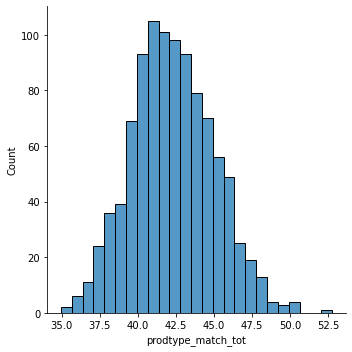

In [28]:
# Filter toners
df_rand_toner = df_rand_res.query("product_type=='toner'")

# plot toner null distribution
sns.displot(df_rand_toner, x="prodtype_match_tot")

# Plot distribution with line for actual estimate
#plt.axvline(df_temp.at[0,'prodtype_match_tot'])

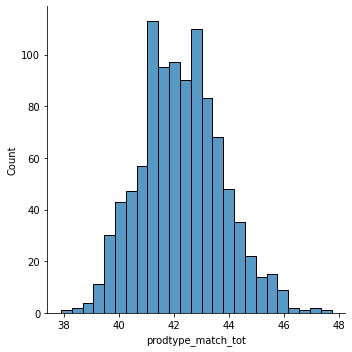

In [30]:
# Filter face washes
df_rand_wash = df_rand_res.query("product_type=='face wash'")

# plot face wash null distribution
sns.displot(df_rand_wash, x="prodtype_match_tot")

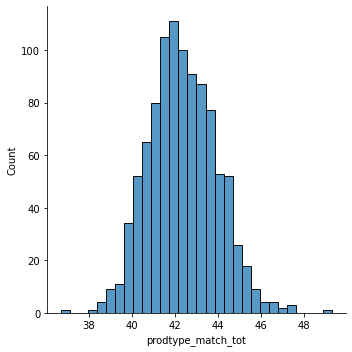

In [31]:
# Filter serum
df_rand_serum = df_rand_res.query("product_type=='face serum'")

# plot serum null distribution
sns.displot(df_rand_serum, x="prodtype_match_tot")

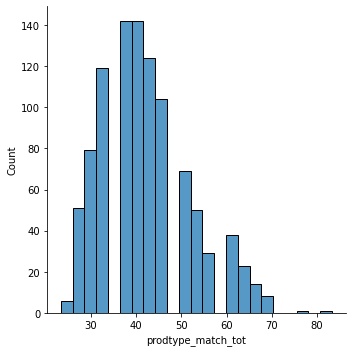

In [32]:
# Filter toothpaste
df_rand_toothpaste = df_rand_res.query("product_type=='toothpaste'")

# plot toothpaste null distribution
sns.displot(df_rand_toothpaste, x="prodtype_match_tot")

In [37]:
df_rand_toothpaste

,product_type,prodtype_match_tot,iteration
4,toothpaste,36.666667,0
10,toothpaste,43.333333,1
16,toothpaste,46.666667,2
22,toothpaste,60.000000,3
28,toothpaste,46.666667,4
...,...,...,...
5974,toothpaste,46.666667,995
5980,toothpaste,46.666667,996
5986,toothpaste,36.666667,997
5992,toothpaste,36.666667,998


In [39]:
# Calculate p-value for randomization

subset_df = df_rand_toothpaste[df_rand_toothpaste["prodtype_match_tot"] >= df_temp.at[4,'prodtype_match_tot']]
column_count = subset_df.count()

sum(column_count)/1000

0.0

In [34]:
len(df_rand_toothpaste)

1000

In [27]:
# get mean of null distribution
df_rand_moist.mean()

prodtype_match_tot     42.172334
iteration             499.500000
dtype: float64

In [241]:
ordered_df['prodtype_match_tot'].values

array([86.66666667, 97.10843373, 98.56540084, 98.95470383, 99.3258427 ,
       98.70454545])

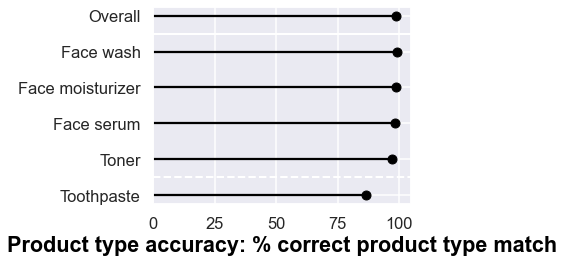

In [289]:
# Plot product accuracy: All product types and overall

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("talk")

# Set style
sns.set_style("darkgrid")

# Plot horizontal bar plot
#p = sns.barplot(x="prodtype_match_tot", y="product_type", data=test)

# Capitalize product types
test['product_type'] = test['product_type'].str.capitalize()

# Reorder it following the values:
ordered_df = test.reindex([4,3,1,0,2,5]).reset_index(drop=True) # Order of x axis values
my_range=range(1,len(ordered_df.index)+1) #y axis range

plt.hlines(y=my_range, xmin=0, xmax=ordered_df['prodtype_match_tot'], color='black')
plt.plot(ordered_df['prodtype_match_tot'], my_range, "o", color='black')

# Set labels
#p.set(ylabel="Product Type", xlabel="Accuracy: % correct product type match")

plt.xlabel('Product type accuracy: % correct product type match', size = 10, fontsize='large', fontweight='bold',
           color = 'black')
plt.ylabel('', rotation='horizontal', fontsize='large', fontweight='bold', color = 'black')
plt.yticks(my_range, ordered_df['product_type'])
plt.xlim([0,105])

# differentiate toothpaste category
plt.axhline(y = 1.5, ls='--', linewidth=2, color='white', xmin=0, xmax=1)

# Add line differentiating categories from overall
plt.axhline(y = 5.5, ls='-', linewidth=2, color='white', xmin=0, xmax=1)

# Add tight layout so y axis labels don't get cut off
plt.tight_layout()

# Save plot
plt.savefig(f"{path}/plots/product_type_acc_all.png", dpi=300,
           orientation='landscape', pad_inches=0.2)

<ipython-input-297-d0937b9ad11f>:48: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "figsize" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(f"{path}/plots/product_type_acc_overall.png", dpi=1000, figsize=[8, 6],


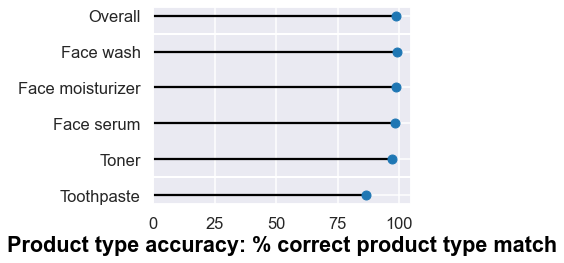

In [297]:
# Plot product accuracy: All product types and overall

import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set_style("darkgrid")

# Plot horizontal bar plot
#p = sns.barplot(x="prodtype_match_tot", y="product_type", data=test)

# Capitalize product types
test['product_type'] = test['product_type'].str.capitalize()

# Create a color if the group is "B"
# my_color=np.where(test['product_type']=='Overall', 'orange',
#                   np.where(test['product_type']=='Toothpaste', 'skyblue', 'black'))
#my_size=np.where(test['product_type']=='Overall', 70,
#                  np.where(test['product_type']=='Toothpaste', 70, 30))

# Reorder it following the values:
ordered_df = test.reindex([4,3,1,0,2,5]).reset_index(drop=True) # Order of x axis values
ordered_df.replace([86.66666667, 97.10843373, 98.56540084, 98.95470383, 99.3258427],0)
my_range=range(1,len(ordered_df.index)+1) #y axis range

plt.hlines(y=my_range, xmin=0, xmax=ordered_df['prodtype_match_tot'], color='black')
plt.plot(ordered_df['prodtype_match_tot'], my_range, "o")

# Set labels
#p.set(ylabel="Product Type", xlabel="Accuracy: % correct product type match")

plt.xlabel('Product type accuracy: % correct product type match', size = 4, fontsize='large', fontweight='bold',
           color = 'black')
plt.ylabel('', rotation='horizontal', fontsize='large', fontweight='bold', color = 'black')
plt.yticks(my_range, ordered_df['product_type'])
plt.xlim([0,105])

# differentiate toothpaste category
plt.axhline(y = 1.5, ls='-', linewidth=2, color='white', xmin=0, xmax=1)

# Add line differentiating categories from overall
plt.axhline(y = 5.5, ls='-', linewidth=2, color='white', xmin=0, xmax=1)

# Add tight layout so y axis labels don't get cut off
plt.tight_layout()

# Save plot
plt.savefig(f"{path}/plots/product_type_acc_overall.png", dpi=1000, figsize=[8, 6],
           orientation='landscape', pad_inches=0.2)

In [281]:
my_size

array([30, 30, 30, 30, 70, 70])

In [266]:
ordered_df.replace(to_replace = [86.66666667, 97.10843373, 98.56540084, 98.95470383, 99.3258427], value=0, inplace=True)
ordered_df.[ordered_df['prodtype_match_tot'] != 98.704545] = 0

In [267]:
ordered_df

,product_type,prodtype_match_tot
0,0,0.0
1,0,0.0
2,0,0.0
3,0,0.0
4,0,0.0
5,0,0.0


In [75]:
## Calculate average product type accuracy

# df to store results
res_sim_prodtype=df[['product','brand','product_type']].copy()

# add empty column for storing results
#res_sim_prodtype['prodtype_match_tot'] = np.nan

prodtype_match_tot = []
#prodtype_match_tot
#

# for each product in df, 
# 1. Get top 6 similiar products, including self
# 2. Count number of products, excluding self, that match input product type
# 3. Add result to df for each product
for i in range(df.shape[0]):
    # Get product name value
    prod_name = df['product'].iloc[i]
    # Calc cosine similarity for the product
    tmp_cosine = cosine_similarity(features.loc[prod_name,:].to_frame().transpose(), features)
    tmp_cosine = tmp_cosine.reshape(-1)
    tmp_cosine = pd.DataFrame(tmp_cosine)
    # Copy df for storing tmp similarity result
    tmp_sim=df[['product','brand','product_type','price','price_oz']].copy()
    # Add similarity to df
    tmp_sim['similarity']=tmp_cosine[[0]]
    # Sort from top similarity metrics and extract top 6, including self
    tmp_top_sim = tmp_sim.nlargest(6, 'similarity')[0:6]
    # Store result in res_sim_prodtype df outside for loop
    ## Store input product type in tmp_prodtype
    tmp_prodtype = tmp_top_sim.loc[tmp_top_sim['product']==prod_name,['product_type']].values[0]
    ## Check match between input prod type and prod_types in sim output and sum matches
    ## -1 to account for matching with self
    prodtype_match_tot.append(tmp_top_sim['product_type'].isin(tmp_prodtype).sum()-1)
    
    #res_sim_prodtype.loc[res_sim_prodtype['prodtype_match_tot']].append(tmp_top_sim['product_type'].isin(tmp_prodtype).sum()-1)
    

IndexError: index 0 is out of bounds for axis 0 with size 0

In [358]:
top_sim = res_sim.nlargest(6, 'similarity')[1:6]
#best_sim_score = min(max(top_sim['similarity'] + min(top_sim['price_oz'])))
#best_sim_score
test=top_sim.iloc[0].to_frame().transpose()[['brand','product','price','price_oz','size','link']]

In [359]:
test

,brand,product,price,price_oz,size,link
111,Curél,Foaming Facial Wash,20,4,5,https://www.ulta.com/foaming-facial-wash?produ...


In [505]:
### TEST STREAMLIT AREA
prod_type = 'face wash'

In [511]:
df.columns

Index(['product', 'brand', 'product_type', 'active', 'price', 'size',
       'ratings', 'total_reviews', 'link', 'price_oz',
       ...
       '190', '191', '192', '193', '194', '195', '196', '197', '198', '199'],
      dtype='object', length=210)

In [521]:
df2 = df[df.product_type==(f'{prod_type}')]

In [523]:
df2.brand.unique()

array(['Philosophy', 'Murad', 'CeraVe', 'Peter Thomas Roth',
       'The Ordinary', 'PEACH & LILY', 'Tula', 'INDIE LEE', 'Dermalogica',
       'Banila Co', 'It Cosmetics', 'Garnier', 'Clinique',
       'The Body Shop', 'Origins', 'Mario Badescu', 'La Roche-Posay',
       'Proactiv', 'Cetaphil', 'Perricone MD', 'Clarins',
       'Kate Somerville', "Kiehl's Since 1851", 'boscia', 'Shiseido',
       'COSRX', 'Derma E', 'bareMinerals', 'Formula 10.0.6',
       'Skyn Iceland', 'Jack Black', 'Juice Beauty', 'ELEMIS',
       'Kopari Beauty', 'PÜR', 'Dermadoctor', 'Pacifica', 'Exuviance',
       'Neutrogena', 'Curél', 'Skinfood', 'Bliss', 'No7', 'My Clarins',
       'ULTA', 'YourGoodSkin', 'ARCONA', 'UpCircle', "L'Occitane",
       'Fifth & Root', 'DHC', 'Hey Honey', 'Botanics', 'Pixi',
       'Milk + Honey', 'Leaders', 'Ofra Cosmetics', 'Follain', 'Clarisma',
       'THANN', 'Yes to', 'ACURE', 'Peach Slices', 'Honest Beauty',
       'Estée Lauder', 'Bioré', 'Hanskin', 'e.l.f. Cosmetics',
    

In [370]:
tempdf = df.loc[df['product']==f'{product}']
df.loc[df['product']==f'{product}']

,product,brand,product_type,price,size,ratings,total_reviews,link,price_oz,0,...,190,191,192,193,194,195,196,197,198,199
111,Foaming Facial Wash,Curél,face wash,20.0,5.0,4.6,240.0,https://www.ulta.com/foaming-facial-wash?produ...,4.0,1.305882,...,0.230863,-0.072649,-0.010053,-0.149319,0.050311,0.018858,0.035698,0.076982,-0.042091,0.05028


In [387]:
price_diff = tempdf['price_oz']-output_rec['price_oz']

In [396]:
tempdf = df.loc[df['product']==f'{product}']
test.iloc[1]['price_oz']
#price_diff = tempdf['price_oz']-test['price_oz']
#price_diff=price_diff.astype('float')
#price_diff
#tempdf['price_oz']
#price_diff
#test=price_diff.values[0]
#test
#f"test price:{test}"

3.6

In [328]:
output_rec = top_sim.iloc[0].to_frame().transpose()[['product_type', 'brand','product','price','price_oz','size','link']]
output_rec

,product_type,brand,product,price,price_oz,size,link
111,face wash,Curél,Foaming Facial Wash,20,4,5,https://www.ulta.com/foaming-facial-wash?produ...


In [411]:
tempdf = df.loc[df['product']==f'{product}']
res_sim
#tempdf
price_diff = tempdf['price_oz']-output_rec['price_oz']
#price_diff
#res_sim['price_oz']
#price_diff
#tempdf['price_oz']#-res_sim['price_oz']
top_sim = res_sim.nlargest(6, 'similarity')[1:6]
output_rec = top_sim.iloc[1].to_frame().transpose()[['product_type', 'brand','product', 'similarity','price','price_oz','size','link']]
output_rec['similarity']=output_rec['similarity'].astype(float)
output_rec['similarity']=round(output_rec['similarity'],2)
#output_rec
#tempdf = df.loc[df['product']==f'{product}']
#tempdf
output_rec['similarity']

60    0.73
Name: similarity, dtype: float64

In [284]:
product_input=df.loc[df['product']==f'{product}']
product_input

,product,brand,product_type,price,size,ratings,total_reviews,link,price_oz,0,...,190,191,192,193,194,195,196,197,198,199
111,Foaming Facial Wash,Curél,face wash,20.0,5.0,4.6,240.0,https://www.ulta.com/foaming-facial-wash?produ...,4.0,1.305882,...,0.230863,-0.072649,-0.010053,-0.149319,0.050311,0.018858,0.035698,0.076982,-0.042091,0.05028


In [282]:
cosine_similarity(product_input) 

ValueError: could not convert string to float: 'Foaming Facial Wash'

In [259]:
top_sim[:1]

NameError: name 'top_sim' is not defined

In [245]:
(((0.881751+0.766394+0.629398)/3) + ((0.629398+0.526911+0.539059)/3) +
((0.881751+0.757364+0.526911)/3) + ((0.766394+0.757364+0.539059)/3))/4

0.6834795

In [219]:
test
#np.minimum(test['similarity'],test['price_oz'])
min(max(test.similarity),min(test.price_oz))

0.785614939701423

In [141]:
features.index
#features.loc["Essential-C Cleanser",:]  #"'Buffet' + Copper Peptides 1%"
features.loc["Essential-C Cleanser",:].to_frame().transpose()

,0,1,2,3,4,5,6,7,8,9,...,60,61,62,63,64,65,66,67,68,69
Essential-C Cleanser,1.692273,-0.334327,-0.1981,-0.721162,0.311682,0.403308,0.134368,0.140876,-0.073881,0.085826,...,-0.067952,0.092941,-0.085718,0.083519,-0.02647,0.095582,-0.092331,0.176955,-0.006216,-0.021925


In [157]:
features.loc["Essential-C Cleanser",:].to_frame().transpose()
#features.loc[0,["Essential-C Cleanser"]]

,0,1,2,3,4,5,6,7,8,9,...,60,61,62,63,64,65,66,67,68,69
Essential-C Cleanser,1.692273,-0.334327,-0.1981,-0.721162,0.311682,0.403308,0.134368,0.140876,-0.073881,0.085826,...,-0.067952,0.092941,-0.085718,0.083519,-0.02647,0.095582,-0.092331,0.176955,-0.006216,-0.021925


In [191]:
#res_cosine
res_cosine.nlargest(6, 0)[1:6]

,0
66,0.883107
5,0.877325
42,0.873452
29,0.866865
16,0.865999


In [150]:
features.loc["Essential-C Cleanser":]

,0,1,2,3,4,5,6,7,8,9,...,60,61,62,63,64,65,66,67,68,69
product,,,,,,,,,,,,,,,,,,,,,
Essential-C Cleanser,1.692273,-0.334327,-0.198100,-0.721162,0.311682,0.403308,0.134368,0.140876,-0.073881,0.085826,...,-0.067952,0.092941,-0.085718,0.083519,-0.026470,0.095582,-0.092331,0.176955,-0.006216,-0.021925
Squalane Cleanser,1.838453,-0.752250,-0.164121,-0.689460,-0.311128,0.151342,0.332328,-0.106218,0.363916,0.319669,...,0.212272,-0.010433,0.038155,0.093323,0.041337,0.168622,0.119676,0.056650,-0.019799,0.168964
Purity Made Simple One-Step Facial Cleanser,1.564310,-0.339959,-0.317187,-0.864637,0.188944,0.069568,-0.032678,0.206118,0.212718,0.168260,...,0.133295,-0.026537,0.041422,0.100734,-0.078355,-0.046946,-0.008473,-0.007212,0.088524,0.055125
Brightening Cleanser,1.248828,-0.344294,-0.385217,-0.995253,0.086369,0.310106,0.041395,0.068215,0.149334,-0.177795,...,0.065994,0.031752,0.022277,0.041208,0.012039,-0.063189,-0.020513,0.022545,0.022670,0.007932
Clearing Skin Wash,1.350051,-0.430794,-0.331308,-1.036320,0.214340,0.366983,0.067601,0.027319,0.002637,-0.181765,...,-0.051091,0.071525,-0.009760,0.095336,0.025304,-0.013245,0.066164,-0.105907,-0.008021,0.103390
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Eudermine Revitalizing Essence,1.837895,0.889976,0.714020,0.132062,0.201420,0.145071,-0.139853,0.036491,-0.158056,0.094124,...,0.136366,0.079923,-0.210101,-0.209674,0.192691,-0.182414,-0.020472,-0.107882,-0.063180,-0.123752
Clear Days Ahead Dark Spot Correcting Serum,2.132511,1.017764,0.791828,0.187813,-0.154457,-0.423460,-0.627530,0.031894,-0.299987,-0.205561,...,-0.197508,0.088492,-0.300584,0.207109,0.094458,-0.072442,0.022628,0.170735,-0.379839,-0.065045
Strawberry Face Milk,1.533950,0.854930,0.455310,-0.306063,-0.493976,-0.458818,0.303550,-0.352652,0.383301,-0.297705,...,-0.148259,0.140489,0.263003,-0.248861,-0.060501,0.046452,0.190982,0.184956,0.297889,-0.172348


In [270]:
#df.loc[df['brand']=='The Ordinary']
#df.loc[df['brand']=='CeraVe']
#df.loc[df['brand']=='Kate Somerville'] # INDIE LEE
#df.loc[df['brand']=='Walgreens']
#df.loc[df['brand']=='SUNDAY RILEY']
df.loc[df['product_type']=='toothpaste']
#df.loc[df['product_type']=='toner']
#df['brand'].unique()

,product,brand,product_type,active,price,size,ratings,total_reviews,link,price_oz,...,11,12,13,14,15,16,17,18,19,vit_a
81,Anticavity Fluoride Toothpaste with Whitening ...,Colgate MaxFresh,toothpaste,no_actives,3.49,6.0,4.7,71,https://www.walgreens.com/store/c/colgate-maxf...,0.58,...,0.364934,-0.258420,-0.204326,-0.151868,-0.134051,-0.265820,0.070817,-0.069748,0.183433,0
83,Antiplaque & Whitening Toothpaste Peppermint,Tom's of Maine,toothpaste,no_actives,4.69,5.5,4.7,40,https://www.walgreens.com/store/c/tom's-of-mai...,0.85,...,0.467464,-0.326626,-0.322941,-0.474443,-0.375929,-0.197295,0.048330,-0.172354,0.149562,0
305,Extreme Whitening Control with Baking Soda & P...,Arm & Hammer Advance White,toothpaste,no_actives,3.09,6.0,4.5,141,https://www.walgreens.com/store/c/arm-%26-hamm...,0.52,...,0.128863,-0.027089,-0.068394,-0.050285,-0.038177,-0.008765,0.012711,-0.008433,0.067649,0
346,Gentle Mint Fluoride Toothpaste Mint,Biotene,toothpaste,no_actives,6.29,4.3,3.9,126,https://www.walgreens.com/store/c/biotene-gent...,1.46,...,0.538919,-0.311649,-0.270193,-0.454072,-0.329241,-0.224782,0.097987,-0.147139,0.228679,0
543,Peppermint Toothpaste Peppermint,Dr. Bronner's,toothpaste,no_actives,3.99,5.0,4.8,23,https://www.walgreens.com/store/c/dr.-bronner'...,0.80,...,0.170493,-0.369043,-0.120450,-0.441453,-0.180181,-0.197644,0.045525,-0.055258,0.180599,0
715,Sensitivity Whitening Plus Scope Toothpaste Mi...,Crest,toothpaste,no_actives,4.99,6.0,4.7,117,https://www.walgreens.com/store/c/crest-sensit...,0.83,...,0.534931,-0.405924,-0.260736,-0.511812,-0.342420,-0.309805,0.027897,-0.111844,0.253386,0


In [539]:
df.loc[df['brand']=='SUNDAY RILEY'] #and df['brand']=='Peter Thomas Roth'

,product,brand,product_type,active,price,size,ratings,total_reviews,link,price_oz,...,190,191,192,193,194,195,196,197,198,199
243,Ceramic Slip Cleanser,SUNDAY RILEY,face wash,no_actives,35.0,5.00,3.2,33,https://www.ulta.com/ceramic-slip-cleanser?pro...,7.00,...,-0.187263,0.103627,-0.270397,0.180683,0.205262,-0.164381,-0.117768,0.035231,0.043439,-0.007248
295,Pink Drink Firming Resurfacing Essence,SUNDAY RILEY,toner,no_actives,48.0,6.75,5.0,2,https://www.ulta.com/pink-drink-firming-resurf...,7.11,...,0.164633,0.048259,0.203004,0.207086,0.126628,-0.005133,-0.071766,0.184104,-0.083599,-0.143462
